In [83]:
# Run this cell
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

%matplotlib inline
import re
import nltk
import string
# run this in cmd to avoid an error beforehand for this import
# python -m nltk.downloader stopwords punkt
from nltk.corpus import stopwords

import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support


In [84]:
PUNCT_TO_REMOVE = string.punctuation
STOPWORDS = set(stopwords.words('english'))

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])


In [85]:
df = pd.read_csv('train.csv')
df["text"] = df["text"].str.lower()
df["text"] = df["text"].apply(lambda text: remove_urls(text))
df["text"] = df["text"].apply(lambda text: remove_punctuation(text))
df["text"] = df["text"].apply(lambda text: remove_stopwords(text))
print(df["text"][7607])


stormchase violent record breaking ef5 el reno oklahoma tornado nearly runs


In [86]:
def randNoun(lines):
    # function to test if something is a noun
    is_noun = lambda pos: pos[:2] == 'NN'
    # do the nlp stuff
    tokenized = nltk.word_tokenize(lines)
    nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
    if (len(nouns) == 0): # if no nouns picked up return rand word in text
        return lines[random.randrange(len(lines))]
    return nouns[random.randrange(len(nouns))]

In [87]:
# preprocessing of the dataset
print(len(df["location"]))
words = {} # will hold unique keywords
count = 0
# getting rid of %20 in keyword and getting a list of all the unqiue keywords
for i in df["keyword"]:
    i = str(i).replace("%20", ' ')
    if (i not in words.keys() and i != "nan"):
        words[i] = count
        count+=1

# filling in missing feature values
# missing keywords get filled in with a keywords already in "words" if that keyword shows up in text, otherwise pick a random word from text
# Missing "location" gets filled in with "Earth"
for i,j in df.iterrows():
    if (pd.isna(j["keyword"])):
        for k in words.keys():
            if k in j["text"]:
                df.at[i, "keyword"] = k
            else:
                df.at[i, "keyword"] = randNoun(j["text"])
    if (pd.isna(j["location"])):
        df.at[i, "location"] = "Earth"
# for i, j in df.iterrows():
#     if (pd.isna(j["location"])):
#         df.drop(i, axis=0, inplace=True)

print(len(df["text"]))


7613
7613


In [88]:
# df.reset_index(inplace=True, drop=True)
# df.head()
corpus = df["text"].to_list()
print(corpus[7608])
word = "el"
count = 0
for i in corpus:
    if word in i:
        count+=1

print(count)
print(len(corpus))

two giant cranes holding bridge collapse nearby homes
1685
7613


In [89]:
# we are going to feature transform 
corpus = df["text"].to_list() # combine all text to a bag of words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus).toarray() # TF-IDF text encoding



#doing hot and cold encoding for keywords
words = {} # will hold unique keywords with a corresponding index
count = 0
for i in df["keyword"]:
    if (i not in words.keys()):
        words[i] = count
        count+=1
print(words)
keywords_hot_cold = np.zeros((len(df["keyword"]), len(words.keys()))) # init feature shape
for i in range(keywords_hot_cold.shape[0]):
    row = np.zeros(keywords_hot_cold.shape[1])
    row[words[df.at[i, "keyword"]]] = 1 # using the index found in the dict, index the row and set the corresponding value of the keyword to 1
    keywords_hot_cold[i] = row


#doing hot and cold encoding for locations
locations = {}
count = 0
for i in df["location"]:
    if (i not in locations.keys()):
        locations[i] = count
        count+=1
location_hot_cold = np.zeros((len(df["location"]), len(locations.keys())))
for i in range(location_hot_cold.shape[0]):
    row = np.zeros(location_hot_cold.shape[1])
    row[locations[df.at[i, "location"]]] = 1
    location_hot_cold[i] = row



# print(np.max(locations_vector))




{'deeds': 0, 'sask': 1, 'orders': 2, 'alaska': 3, 'california': 4, 'springs': 5, 'hill': 6, 'emergency': 7, 'im': 8, 'people': 9, 'haha': 10, 'days': 11, 'bago': 12, 'crash': 13, 'whats': 14, 'fruits': 15, 'summer': 16, 'car': 17, 'goooooooaaaaaal': 18, 's': 19, 'cool': 20, 'skiing': 21, 'day': 22, 'looooool': 23, 'shit': 24, 'week': 25, 'girlfriend': 26, 'cooool': 27, 'pasta': 28, 'end': 29, 'ablaze': 30, 'accident': 31, 'aftershock': 32, 'airplane%20accident': 33, 'ambulance': 34, 'annihilated': 35, 'annihilation': 36, 'apocalypse': 37, 'armageddon': 38, 'army': 39, 'arson': 40, 'arsonist': 41, 'attack': 42, 'attacked': 43, 'avalanche': 44, 'battle': 45, 'bioterror': 46, 'bioterrorism': 47, 'blaze': 48, 'blazing': 49, 'bleeding': 50, 'blew%20up': 51, 'blight': 52, 'blizzard': 53, 'blood': 54, 'bloody': 55, 'blown%20up': 56, 'body%20bag': 57, 'body%20bagging': 58, 'body%20bags': 59, 'bomb': 60, 'bombed': 61, 'bombing': 62, 'bridge%20collapse': 63, 'buildings%20burning': 64, 'buildings

In [90]:
count = 0
fracs = 0
for i in X:
    for j in i:
        if j>=1:
            count+=1
        if j<1 and j!=0:
            fracs+=1

print(count)
print(fracs)
print(X.shape[0] * X.shape[1])

41
69098
134856682


In [51]:
# combine all features and split into training and validation sets

X = np.hstack((keywords_hot_cold, location_hot_cold, X))
# scalar = StandardScaler()
# scalar.fit(X)
# X = scalar.fit_transform(X)
# X = keywords_hot_cold
# X_train = X
# y_train = df["target"]
X = X
X_train, X_val,  y_train, y_val = train_test_split(X, df["target"], test_size=.4)

# X_train = scalar.fit_transform(X_train)
# X_val = scalar.fit_transform(X_val)

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()


# poly = PolynomialFeatures(1)
# X_train = poly.fit_transform(X_train)
# X_val = poly.fit_transform(X_val)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(4567, 28541) (4567,) (3046, 28541) (3046,)


45719


In [52]:
lmdas = [.002, .001, .0005, .0001, .00001, .000005]

penalty = ['l1', 'l2']


In [53]:
from sklearn import linear_model
results = []
for pen in range(len(penalty)):
    results.append([])
    for lmda in range(len(lmdas)):
        results[pen].append([])
        logreg = linear_model.SGDClassifier(penalty = penalty[pen], alpha = lmdas[lmda], max_iter=2000, loss="log_loss")
        logreg.fit(X_train, y_train)
        w_logreg = logreg.coef_
        y_hat_logreg = logreg.predict(X_val)
        # Find the accuracy achieved on test set using logreg.score and y_test 
        
        acc_train = logreg.score(X_train, y_train)
        acc_logreg = logreg.score(X_val, y_val)
        prec, recal, fscore, sup =  precision_recall_fscore_support(y_val, y_hat_logreg, zero_division=True)
        results[pen][lmda].append( {"acc_train": acc_train, "acc_val": acc_logreg, "prec": prec, "recal": recal, "weights":np.sum(w_logreg) + logreg.intercept_[0]})
        print( {"acc_train": acc_train, "acc_val": acc_logreg, "prec": prec, "recal": recal, "weights":np.sum(w_logreg) + logreg.intercept_[0]})


{'acc_train': 0.6041164878476024, 'acc_val': 0.5909389363099147, 'prec': array([0.58015525, 0.97590361]), 'recal': array([0.99883788, 0.06113208]), 'weights': 4.620255872252768}
{'acc_train': 0.7024304795270419, 'acc_val': 0.6868023637557452, 'prec': array([0.65853659, 0.79585327]), 'recal': array([0.92562464, 0.37660377]), 'weights': 18.99536200307788}
{'acc_train': 0.7381213050142326, 'acc_val': 0.7284963887065004, 'prec': array([0.71573359, 0.75564682]), 'recal': array([0.86170831, 0.5554717 ]), 'weights': 29.375474939542148}
{'acc_train': 0.8526384935406175, 'acc_val': 0.7275114904793172, 'prec': array([0.72175212, 0.73866924]), 'recal': array([0.84253341, 0.57811321]), 'weights': 174.12775300600347}
{'acc_train': 0.8900810159842347, 'acc_val': 0.6953381483913329, 'prec': array([0.7005564 , 0.68568756]), 'recal': array([0.80476467, 0.55320755]), 'weights': 434.07567192478956}
{'acc_train': 0.8872345084300416, 'acc_val': 0.6841759684832567, 'prec': array([0.67025572, 0.72215422]), '

In [54]:
print(repr(results))
for i in results:
    print('\n')
    for j in i:
        print(j)



[[[{'acc_train': 0.6041164878476024, 'acc_val': 0.5909389363099147, 'prec': array([0.58015525, 0.97590361]), 'recal': array([0.99883788, 0.06113208]), 'weights': 4.620255872252768}], [{'acc_train': 0.7024304795270419, 'acc_val': 0.6868023637557452, 'prec': array([0.65853659, 0.79585327]), 'recal': array([0.92562464, 0.37660377]), 'weights': 18.99536200307788}], [{'acc_train': 0.7381213050142326, 'acc_val': 0.7284963887065004, 'prec': array([0.71573359, 0.75564682]), 'recal': array([0.86170831, 0.5554717 ]), 'weights': 29.375474939542148}], [{'acc_train': 0.8526384935406175, 'acc_val': 0.7275114904793172, 'prec': array([0.72175212, 0.73866924]), 'recal': array([0.84253341, 0.57811321]), 'weights': 174.12775300600347}], [{'acc_train': 0.8900810159842347, 'acc_val': 0.6953381483913329, 'prec': array([0.7005564 , 0.68568756]), 'recal': array([0.80476467, 0.55320755]), 'weights': 434.07567192478956}], [{'acc_train': 0.8872345084300416, 'acc_val': 0.6841759684832567, 'prec': array([0.6702557

[[{'acc_train': 0.6041164878476024, 'acc_val': 0.5909389363099147, 'prec': array([0.58015525, 0.97590361]), 'recal': array([0.99883788, 0.06113208]), 'weights': 4.620255872252768}], [{'acc_train': 0.7024304795270419, 'acc_val': 0.6868023637557452, 'prec': array([0.65853659, 0.79585327]), 'recal': array([0.92562464, 0.37660377]), 'weights': 18.99536200307788}], [{'acc_train': 0.7381213050142326, 'acc_val': 0.7284963887065004, 'prec': array([0.71573359, 0.75564682]), 'recal': array([0.86170831, 0.5554717 ]), 'weights': 29.375474939542148}], [{'acc_train': 0.8526384935406175, 'acc_val': 0.7275114904793172, 'prec': array([0.72175212, 0.73866924]), 'recal': array([0.84253341, 0.57811321]), 'weights': 174.12775300600347}], [{'acc_train': 0.8900810159842347, 'acc_val': 0.6953381483913329, 'prec': array([0.7005564 , 0.68568756]), 'recal': array([0.80476467, 0.55320755]), 'weights': 434.07567192478956}], [{'acc_train': 0.8872345084300416, 'acc_val': 0.6841759684832567, 'prec': array([0.67025572

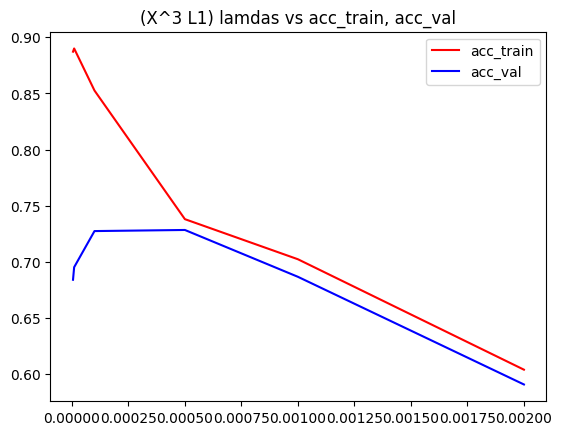

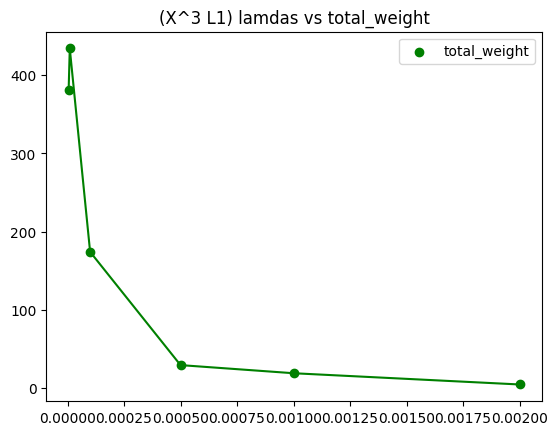

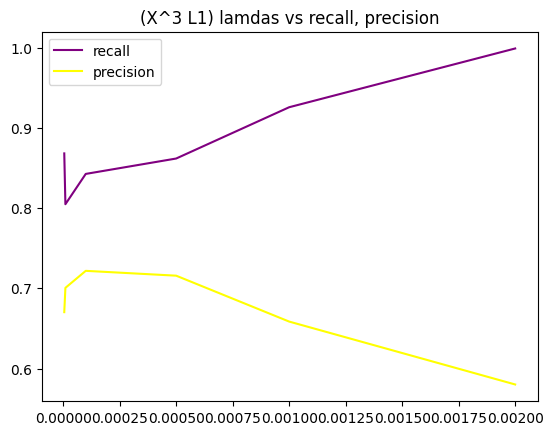

In [57]:
acc_train = []
acc_val = []
weights = []
recall = []
prec = []
specific_result = results[0]
print(specific_result)
for i in range(len(results[0])):
    acc_train.append(specific_result[i][0]["acc_train"])
    acc_val.append(specific_result[i][0]["acc_val"])
    weights.append(specific_result[i][0]["weights"])
    recall.append(specific_result[i][0]["recal"][0])
    prec.append(specific_result[i][0]["prec"][0])

plt.title("(X^3 L1) lamdas vs acc_train, acc_val")
# plt.scatter(lmdas, l1acc_train, color='red', label="acc_train")
# plt.scatter(lmdas, l1acc_val, color='blue', label="acc_val")
plt.plot(lmdas, acc_train, color='red', label = "acc_train")
plt.plot(lmdas, acc_val, color='blue', label = "acc_val")
plt.legend()
plt.show()

plt.title("(X^3 L1) lamdas vs total_weight")
plt.scatter(lmdas, weights, color='green', label="total_weight")
plt.plot(lmdas, weights, color='green')
plt.legend()
plt.show()


plt.title("(X^3 L1) lamdas vs recall, precision")
# plt.scatter(lmdas, l1recall, color='purple',label="recall")
# plt.scatter(lmdas, l1prec, color='yellow', label="precision")
plt.plot(lmdas, recall, color='purple',label="recall")
plt.plot(lmdas, prec, color='yellow', label="precision")
plt.legend()
plt.show()

[[{'acc_train': 0.7803809940880228, 'acc_val': 0.7222586999343401, 'prec': array([0.7112506 , 0.74564103]), 'recal': array([0.85589773, 0.54867925]), 'weights': -2.213737710749349}], [{'acc_train': 0.8018392818042479, 'acc_val': 0.7367038739330269, 'prec': array([0.74770889, 0.71956339]), 'recal': array([0.80592679, 0.64679245]), 'weights': -2.9177519924580615}], [{'acc_train': 0.8324939785417123, 'acc_val': 0.7311227839789889, 'prec': array([0.73151951, 0.73041894]), 'recal': array([0.82800697, 0.60528302]), 'weights': -5.383036476510799}], [{'acc_train': 0.8865776220713817, 'acc_val': 0.7255416940249507, 'prec': array([0.736    , 0.7087959]), 'recal': array([0.80185938, 0.62641509]), 'weights': -15.026746364388327}], [{'acc_train': 0.8846069629954018, 'acc_val': 0.7025607353906763, 'prec': array([0.70528967, 0.69745523]), 'recal': array([0.81348053, 0.55849057]), 'weights': -91.11819750510374}], [{'acc_train': 0.8740967812568425, 'acc_val': 0.6936966513460275, 'prec': array([0.683768

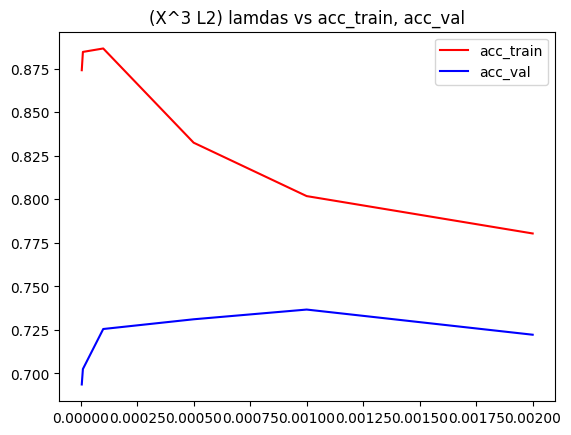

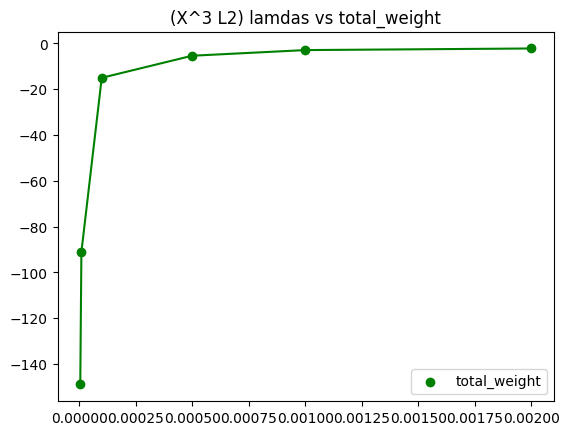

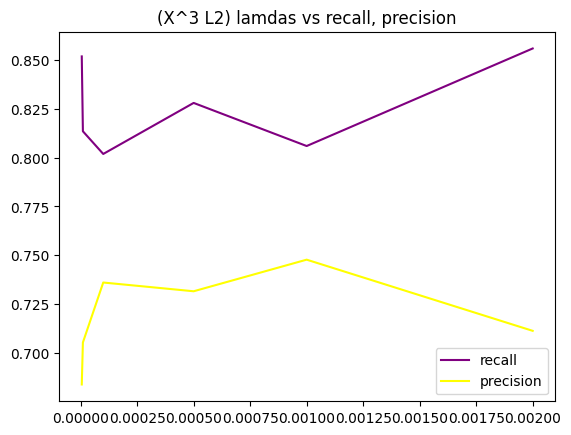

In [58]:
acc_train = []
acc_val = []
weights = []
recall = []
prec = []
specific_result = results[1]
print(specific_result)
for i in range(len(results[1])):
    acc_train.append(specific_result[i][0]["acc_train"])
    acc_val.append(specific_result[i][0]["acc_val"])
    weights.append(specific_result[i][0]["weights"])
    recall.append(specific_result[i][0]["recal"][0])
    prec.append(specific_result[i][0]["prec"][0])



plt.title("(X^3 L2) lamdas vs acc_train, acc_val")
# plt.scatter(lmdas, l1acc_train, color='red', label="acc_train")
# plt.scatter(lmdas, l1acc_val, color='blue', label="acc_val")

plt.plot(lmdas, acc_train, color='red', label="acc_train")
plt.plot(lmdas, acc_val, color='blue', label="acc_val")
plt.legend()
plt.show()

plt.title("(X^3 L2) lamdas vs total_weight")
plt.scatter(lmdas, weights, color='green', label="total_weight")
plt.plot(lmdas, weights, color='green')
plt.legend()
plt.show()


plt.title("(X^3 L2) lamdas vs recall, precision")
# plt.scatter(lmdas, l1recall, color='purple',label="recall")
# plt.scatter(lmdas, l1prec, color='yellow', label="precision")
plt.plot(lmdas, recall, color='purple',label="recall")
plt.plot(lmdas, prec, color='yellow', label="precision")
plt.legend()
plt.show()